### inspired by:
https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-tsne.ipynb

In [1]:
%matplotlib inline
import os
import random
#import cPickle as pickle
import numpy as np
from ggplot import *
from sklearn.decomposition import PCA
import matplotlib.pyplot 
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras import applications
from keras.models import Model
from sklearn.decomposition import PCA
from skimage.util.shape import view_as_windows
from skimage.transform import resize
from scipy.spatial import distance
from tqdm import tqdm
import pandas as pd

/hdd/vova/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/hdd/vova/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/hdd/vova/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
images_path = '/srv/vova/PARSED/JPG_2000/test8000/SSS'
img_width, img_height = 224, 224 ## model input
res=2000
side=img_width
blocks=int(res/side)
window_shape = (img_width, img_height,3)

In [3]:
images_big = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
print("keeping %d big images to analyze" % len(images_big))

keeping 826 big images to analyze


In [4]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
#print(model.summary())

feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
def get_big_image(path):
    img = image.load_img(path)
    x = image.img_to_array(img)
    #x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    return img, x

In [64]:
celimage, imarray = get_big_image(images_big[5])
B = view_as_windows(imarray, window_shape,step=side)
#C = view_as_windows(celimage, window_shape,step=side)
bflat=B.reshape(blocks*blocks,side,side,3)

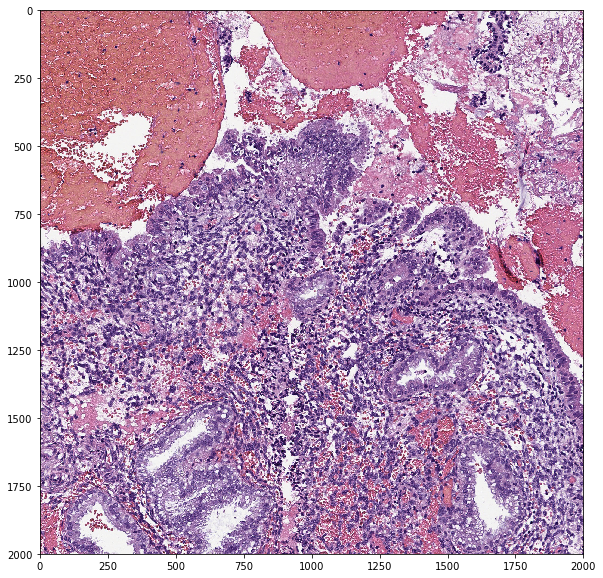

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
imshow(celimage)

In [66]:
x = bflat[1]  # this is a Numpy array with shape (3, 150, 150)
print(x.shape)
x = x.reshape((1,) + x.shape) 
feat_extractor.predict(x)[0]

(224, 224, 3)


array([ 0.        ,  0.86590528,  0.        , ...,  0.        ,
        2.37426686,  0.        ], dtype=float32)

In [67]:
features = []
for x in tqdm(bflat):
    x = x.reshape((1,) + x.shape)
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

100%|██████████| 64/64 [00:02<00:00, 25.58it/s]


In [68]:
features = pd.DataFrame(features)

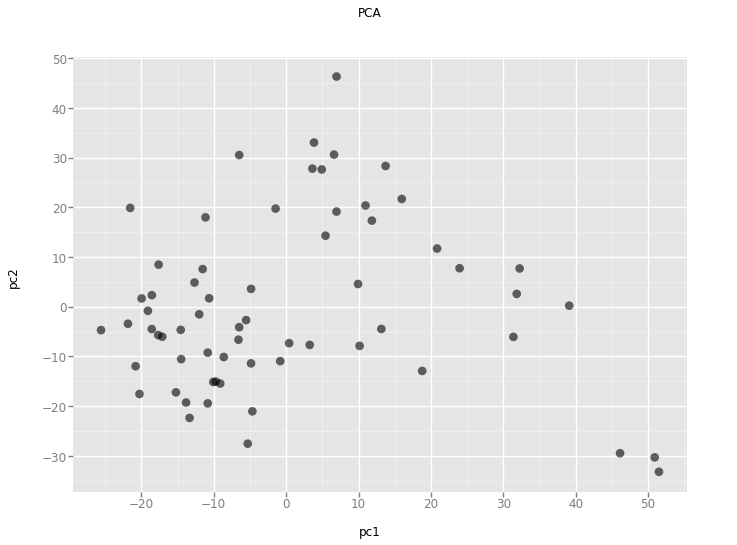

<ggplot: (8752049137728)>

In [69]:
pca = PCA(n_components=2)
_pca = pca.fit(features).transform(features)

pca_df=pd.DataFrame(_pca,columns=['pc1','pc2'])
#pca_df['col']=label_color
pca_df.head()

chart_pca = ggplot(pca_df, aes(x='pc1', y='pc2')) \
        + geom_point(size=75,alpha=0.6) \
        + ggtitle("PCA") 
chart_pca

In [70]:
tx, ty = pca_df.pc1, pca_df.pc2
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

64it [00:00, 640.94it/s]


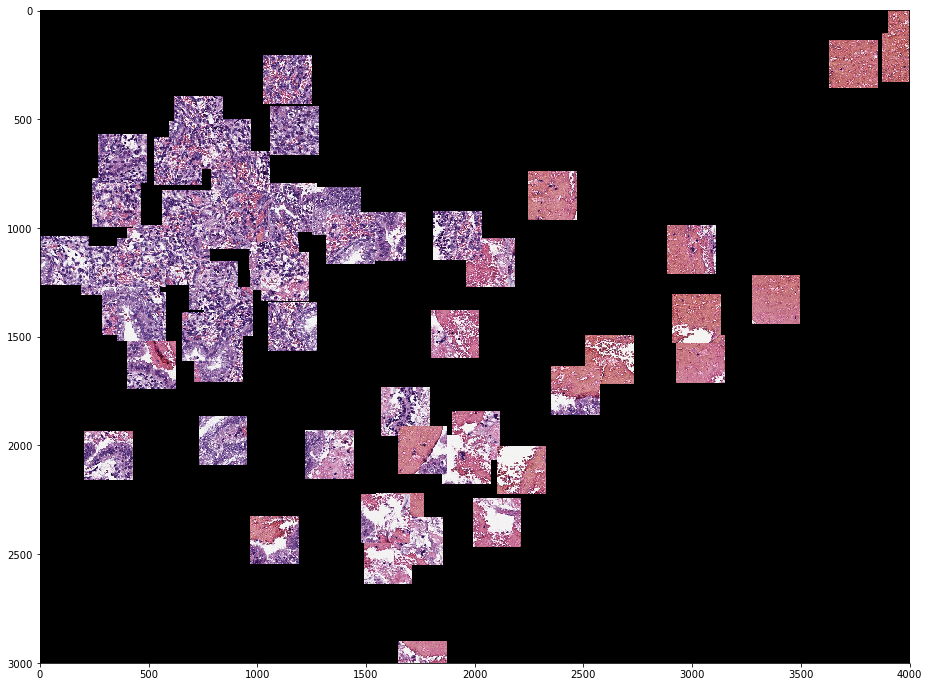

In [71]:
from PIL import Image

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGB', (width, height))
for img, x, y in tqdm(zip(bflat, tx, ty)):
    tile = Image.fromarray(img.astype('uint8'),mode='RGB')   # uint8 is cool addition!
    #rs = max(1, tile.width/max_dim, tile.height/max_dim)
    #tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

64it [00:00, 732.41it/s]


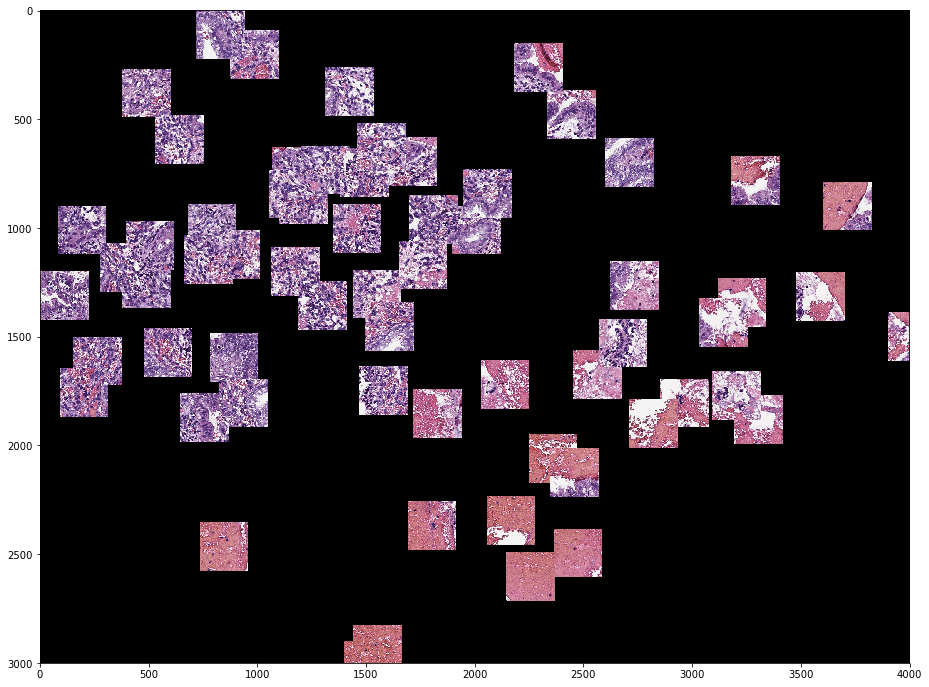

In [72]:
from sklearn.manifold import TSNE
pca = PCA(n_components=200)
_pca = pca.fit(features).transform(features)

X = np.array(_pca)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=45, angle=0.2, verbose=0).fit_transform(X)

tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

full_image = Image.new('RGB', (width, height))
for img, x, y in tqdm(zip(bflat, tx, ty)):
    tile = Image.fromarray(img.astype('uint8'),mode='RGB')   # uint8 is cool addition!
    #rs = max(1, tile.width/max_dim, tile.height/max_dim)
    #tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)